<a href="https://colab.research.google.com/github/banjuk2/github.io/blob/master/CNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* MNIST
- 숫자 형태의 데이터셋 

In [ ]:
# 필요 라이브러리 호출 
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torchvision import datasets,transforms 

import numpy as np
import matplotlib.pyplot as plt 

In [ ]:
# Train, Test 용도 데이터 선택 
train_dataset = datasets.MNIST('./mnist_data', 
                               download=True, 
                               train=True, 
                               transform=transforms.ToTensor(),
                               )
test_dataset = datasets.MNIST('./mnist_data',
                              download=False,
                              train=False,
                              transform = transforms.ToTensor()
                              )

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [ ]:
# 데이터셋 로더 호출 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)

In [18]:
# 장치호출
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [31]:
# Convolutional Neural Network 모델생성 

'''----------------------------
입력텐서(입력이미지) 
(batch, 1, 28, 28) 가로 28, 세로 28, 채널 1(gray image), 이미지 개수는 bactch(128)

신경망 구조

        커널, 입력채널, 출력채널, 스트라이드, 패딩, 출력텐서 
conv    5X5    1        6         1X1         0     (batch, 6, 24, 24)
Maxpool 2X2                       2X2         0     (batch, 6, 12, 12)
conv    5X5    6        16(가정)  1X1         0     (batch, 16, 8, 8)
Maxpool 2X2                       2X2         0     (batch, 16, 4, 4)
Flatten                                             (batch, 16*4*4) -> 벡터

               입력노드,     출력노드
FC             16*4*4        96 (가정)          (batch, 96)
dropout                               20%(가중치행렬의 20%)
FC             96            10                 (batch, 10)
--------------------------------'''

class CNN_MNIST(nn.Module):
    def __init__(self):
        super(CNN_MNIST,self).__init__()
        self.conv1 = nn.Conv2d(1,6,5,1)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5,1)
        self.pool2 = nn.MaxPool2d(2,2)
        self.lin1 = nn.Linear(16*4*4,96)
        self.drop1 = nn.Dropout(0.2)
        self.lin2 = nn.Linear(96,10)
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.shape[0],-1)
        x = F.relu(self.drop1(self.lin1(x)))
        x = F.softmax(self.lin2(x)) # nn.CrossEntropyLoss를 사용하려면 x=self.lin2(x)
        return x




In [32]:
# 확률간 거리 Kullback-Leibler divergence
def kl_div(prob1,prob2):
    '''
    loss function으로 cross entropy 함수 사용 
    prob1: label
    prob2: inference
    '''
    return torch.sum(prob1*torch.log(prob1/prob2+1e-15))

In [33]:
model = CNN_MNIST().to(device) # 모델셍성 
optimizer = optim.Adam(model.parameters(),lr=1e-04) # 옵티마이저 생성 (학습의 대상: kernal, weighted matrix)

 
#criterion = nn.CrossEntropyLoss()으로도 이용 가능
for ep in range(20): # 학습을 20번 반복하여 검증함 
    model.train()
    train_loss = 0
    for X,Y in train_loader: # X(batch, 1, 28, 28), Y(batch, 1) --> (batch, 10)
        X = X.to(device)
        Y = Y.to(device)
        
        # One-hot encoding --> criterion이용하려면 사용금지
        Y_label = torch.zeros((Y.shape[0],10)).to(device)
        Y_label[range(Y.shape[0]),Y]=1
        
        Y_infer = model(X)
        loss = kl_div(Y_label,Y_infer) # 예측한값과 실제값과의 차이(거리) 계산
        #loss = criterion(Y_infer,Y_label)
        optimizer.zero_grad()
        loss.backward() # back progation
        optimizer.step() # optimization 
        
        train_loss += loss.item()
    
    # (테스트 용도로) 중간 모니터링 
    model.eval()
    test_loss = 0
    for X,Y in test_loader:
        X = X.to(device)
        Y = Y.to(device)
        
        Y_label = torch.zeros((Y.shape[0],10)).to(device)
        Y_label[range(Y.shape[0]),Y]=1
        
        Y_infer = model(X)
        loss = kl_div(Y_label,Y_infer)
        
        test_loss += loss.item()
        
    if ep % 5 == 0:
        print('Episode {:d}, Train_loss {:.3f}, Test_loss {:.3f}'
              .format(ep,train_loss/len(train_loader),test_loss/len(test_loader)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Episode 0, Train_loss 181.781, Test_loss 57.576
Episode 5, Train_loss 21.850, Test_loss 15.403
Episode 10, Train_loss 14.047, Test_loss 9.687
Episode 15, Train_loss 10.652, Test_loss 7.435


In [34]:
model.eval()
correct = 0
for X,Y in test_loader:
    X = X.to(device) # 입력 이미지
    Y = Y.to(device) # 실제 레이블
    Y_infer = model(X) # 출력 레이블 
    correct += np.mean(torch.argmax(Y_infer,dim=1).detach().cpu().numpy()==Y.detach().cpu().numpy())
    
print("테스트 데이터 정확도: {:.4f}%"
      .format(100.0*correct/len(test_loader)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


테스트 데이터 정확도: 98.3386%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


실제 이미지 숫자 0
예측 숫자 0


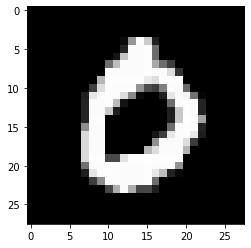

In [37]:
# Checking
X,Y = test_dataset[3]
X = X.to(device)
Y_infer = model(torch.unsqueeze(X,0))

print('실제 이미지 숫자',Y)
print('예측 숫자',np.argmax(Y_infer.detach().cpu().numpy()))
plt.imshow(X.detach().cpu().numpy()[0],cmap='gray')